In [1]:
from model import Encoder, Decoder
from dataloader import Vocabulary, COCODataset, collate_fn
import pickle
from pycocotools.coco import COCO

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import math

In [2]:
with open("/Users/umangshikarvar/Desktop/Project/vocab.pkl", 'rb') as f:
        vocab_dict = pickle.load(f)
vocab = Vocabulary(vocab_dict["word2idx"], vocab_dict["idx2word"])

In [3]:
# Configuration
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)
num_epochs = 5
batch_size = 100
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 10321


In [4]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
])

# Dataset
dataset = COCODataset(image_dir="/Users/umangshikarvar/Desktop/Project/coco/train2017",
                        annotation_path="/Users/umangshikarvar/Desktop/Project/coco/annotations/captions_train2017.json",
                        vocab=vocab,
                        transform=transform)

# Dataloader
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0, 
                        collate_fn=collate_fn,
                        pin_memory=True) 

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [5]:
# Device setup 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Initializing the encoder and decoder
encoder = Encoder(embed_size)
decoder = Decoder(embed_size, hidden_size, vocab_size)

# Initializing the models
encoder = encoder.train()
decoder = decoder.train()

# Move models to device
encoder.to(device)
decoder.to(device)

# Defining the loss function
criterion = (nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss())

# Specifying the learnable parameters of the mode
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# Defining the optimize
optimizer = torch.optim.Adam(params, lr=0.001)

# Set the total number of training steps per epoch
total_step = math.ceil(len(dataloader.dataset) / batch_size)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
for epoch in range(1, num_epochs + 1):
    for i_step in range(1, total_step + 1):

        # Obtain the batch.
        images, captions = next(iter(dataloader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Passing the inputs through the CNN-RNN model
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculating the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backwarding pass
        loss.backward()

        # Updating the parameters in the optimizer
        optimizer.step()

        # Print training statistics
        print(f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{total_step}], Loss: {loss.item():.4f}, Perplexity: {math.exp(loss.item()):.4f}")

    # Save encoder and decoder after each epoch
    torch.save(encoder.state_dict(), f"checkpoints/encoder_epoch_{epoch}.pth")
    torch.save(decoder.state_dict(), f"checkpoints/decoder_epoch_{epoch}.pth")

Epoch [1/5], Step [1/5918], Loss: 9.1700, Perplexity: 9604.8361
Epoch [1/5], Step [2/5918], Loss: 8.6533, Perplexity: 5728.9465
Epoch [1/5], Step [3/5918], Loss: 7.8741, Perplexity: 2628.4016
Epoch [1/5], Step [4/5918], Loss: 7.0092, Perplexity: 1106.7356
Epoch [1/5], Step [5/5918], Loss: 6.7931, Perplexity: 891.6487
Epoch [1/5], Step [6/5918], Loss: 3.0722, Perplexity: 21.5901
Epoch [1/5], Step [7/5918], Loss: 5.7988, Perplexity: 329.8951
Epoch [1/5], Step [8/5918], Loss: 4.8169, Perplexity: 123.5789
Epoch [1/5], Step [9/5918], Loss: 4.6481, Perplexity: 104.3900
Epoch [1/5], Step [10/5918], Loss: 2.6534, Perplexity: 14.2024
Epoch [1/5], Step [11/5918], Loss: 4.2080, Perplexity: 67.2244
Epoch [1/5], Step [12/5918], Loss: 2.6241, Perplexity: 13.7922
Epoch [1/5], Step [13/5918], Loss: 4.2844, Perplexity: 72.5605
Epoch [1/5], Step [14/5918], Loss: 3.4865, Perplexity: 32.6701
Epoch [1/5], Step [15/5918], Loss: 3.7920, Perplexity: 44.3434
Epoch [1/5], Step [16/5918], Loss: 2.7930, Perplexit

In [6]:
# Load the saved weights into these models
encoder.load_state_dict(torch.load("checkpoints/encoder_epoch_5.pth"))
decoder.load_state_dict(torch.load("checkpoints/decoder_epoch_5.pth"))

# Move to appropriate device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
encoder = encoder.to(device)
decoder = decoder.to(device)

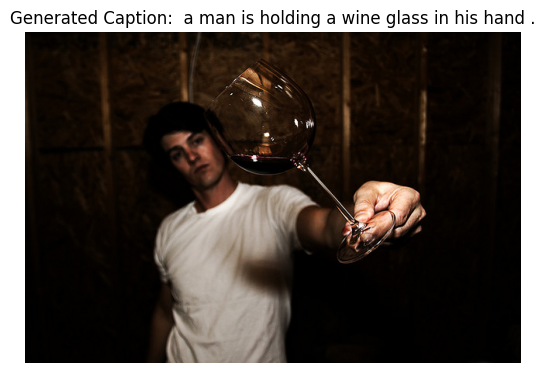

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

encoder.eval()
decoder.eval()

# Load the test image
test_image_path = "/Users/umangshikarvar/Desktop/Project/coco/train2017/000000000326.jpg"  # Replace with the path to your test image
test_image = Image.open(test_image_path).convert("RGB")

def clean_sentence(output, idx2word):
    sentence = ""
    for i in output:
        word = idx2word[i]
        if i == 0 or i==2:  # Start and unknown token
            continue
        if i == 1:          # End of sentence token
            break
        sentence = sentence + " " + word
    return sentence

# Apply transformations to the test image
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Preprocess the test image
test_image = transform_test(test_image).unsqueeze(0)  # Add batch dimension

# Move the preprocessed image to the appropriate device
test_image = test_image.to(device)

# Pass the test image through the encoder
with torch.no_grad():
    features = encoder(test_image).unsqueeze(1)

# Generate captions with the decoder
with torch.no_grad():
    output = decoder.sample(features)

# Convert the output into a clean sentence
caption = clean_sentence(output, vocab.idx2word)

# Display the test image with the generated caption
plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.title('Generated Caption: ' + caption)
plt.show()